In [1]:
# referencias:
# data8.org 
# https://www.inferentialthinking.com/chapters/11/2/bootstrap.html
# https://www.inferentialthinking.com/chapters/16/2/ab-testing.html
# Intermediate Statistics, L. Wasserman. http://www.stat.cmu.edu/~larry/=stat705/

library(tidyverse)
library(ggplot2)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.0     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ dplyr   0.8.2
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


## Percentiles 

Datos numéricos se pueden ordenar. 

Cada valor tiene un rango. 

Un percentíl es el valor de un rango particular. 

In [2]:
x <- c(1, 15, 12, 8, 7)
x

[1]  1 15 12  8  7

In [3]:
sort(x)

[1]  1  7  8 12 15

In [4]:
5*66.5/100

[1] 3.325

12 es mayor o igual al 80% del resto de los números en x. 

El 80 percentíl es 12.

### Función percentíl

    1- Ordenar x, x_s <- sort(x). 
    2- Calcular k <- p*n/100
    3- Si k es un entero x_s[k] es el p-percentíl. Sino usen el mas grande entero próximo. 

In [5]:
percentil <- function(x, p){
    n <- length(x)
    k <- ceiling(p*n/100)
    
    x_s <- sort(x)
    return(x_s[k])
}

In [6]:
percentil(x, 45)

[1] 8

#### Un ejemplo: 

In [9]:
babies <- read.table("../tablas/babies.data", header = TRUE, sep = "")
head(babies)

bwt,gestation,parity,age,height,weight,smoke
<int>,<int>,<int>,<int>,<int>,<int>,<int>
120,284,0,27,62,100,0
113,282,0,33,64,135,0
128,279,0,28,64,115,1
123,999,0,36,69,190,0
108,282,0,23,67,125,1
136,286,0,25,62,93,0


In [10]:
babies_Simple <- babies %>% mutate(ratio_BWG_GEST = bwt/gestation) %>% 
                    select(bwt, gestation, ratio_BWG_GEST, age)

head(babies_Simple)

bwt,gestation,ratio_BWG_GEST,age
<int>,<int>,<dbl>,<int>
120,284,0.4225352,27
113,282,0.4007092,33
128,279,0.4587814,28
123,999,0.1231231,36
108,282,0.3829787,23
136,286,0.4755245,25


In [11]:
babies_Simple %>% summarize(promedio_pob = mean(ratio_BWG_GEST))

promedio_pob
<dbl>
0.4248326


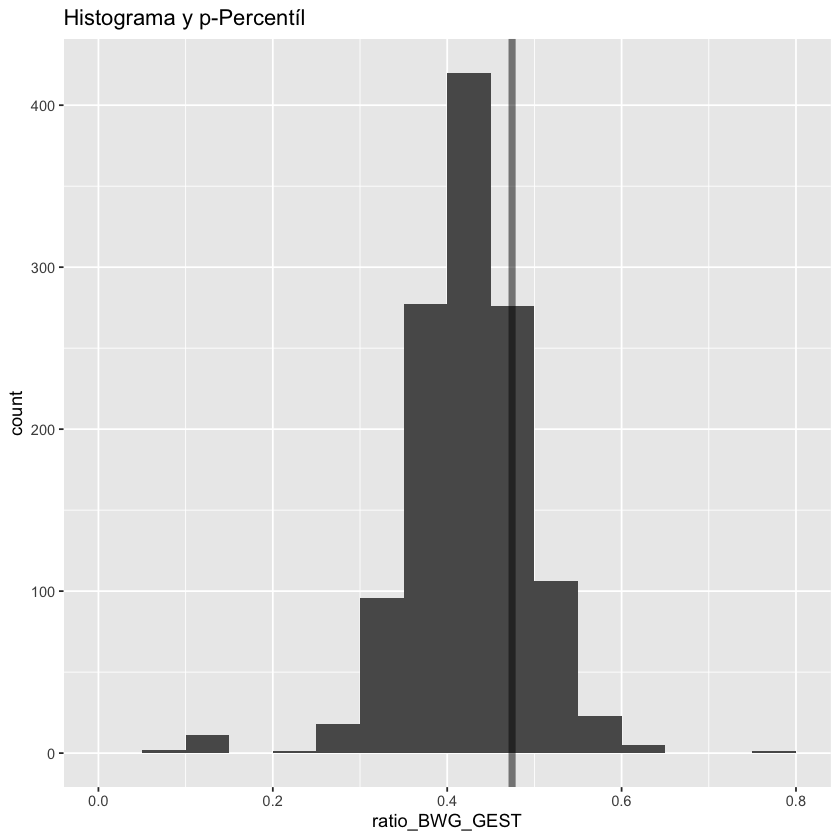

In [12]:
ggplot(babies_Simple, aes(x = ratio_BWG_GEST)) + 
    geom_histogram(breaks = seq(0, 0.8, 0.05)) + 
    geom_vline(xintercept = percentil(babies_Simple$ratio_BWG_GEST, 80), 
               size = 2, alpha=0.5) + 
    ggtitle("Histograma y p-Percentíl")

### Bootstrap

Voy a asumir que solo tengo 500 muestras de la población. 

In [13]:
dim(babies_Simple)

[1] 1236    4

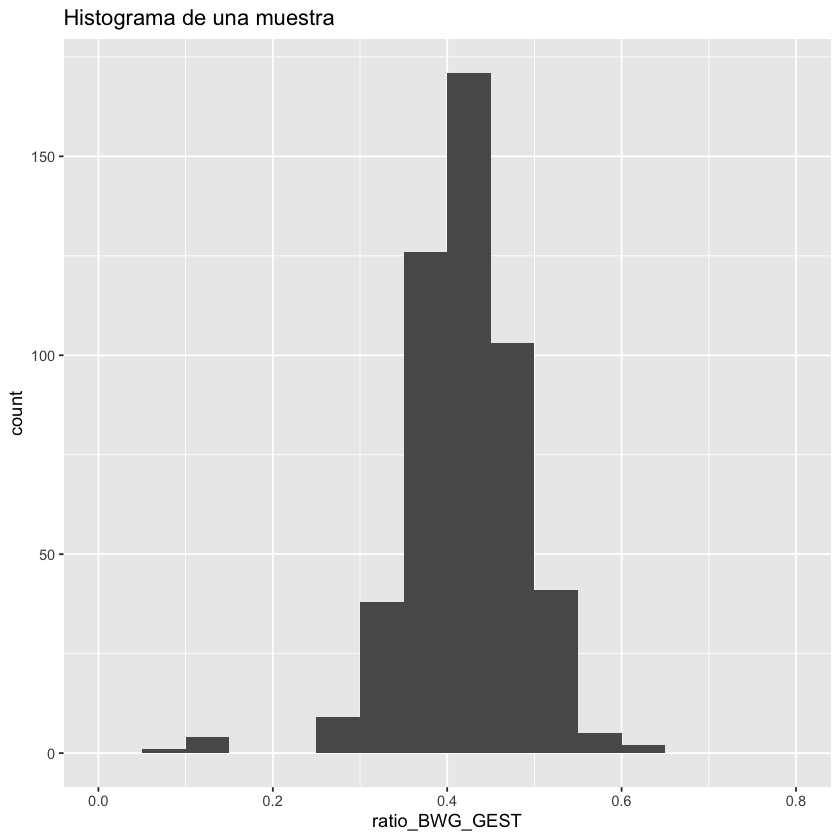

In [14]:
index <- sample(1:1236, 500)
babies_Sample <- babies_Simple %>% slice(index)

ggplot(babies_Sample, aes(x = ratio_BWG_GEST)) + geom_histogram(breaks = seq(0, 0.8, 0.05)) +
    ggtitle("Histograma de una muestra")

### Estimar el peso/semanas de Gestación

In [15]:
babies_Sample %>% summarize(promedio = mean(ratio_BWG_GEST), mediana = median(ratio_BWG_GEST))

promedio,mediana
<dbl>,<dbl>
0.420827,0.422597


### Qué tan diferente puede ser nuestra estimación si la muestra cambia? 

Estimación y cuantificar el error en la estimación.  

Una idea: construir un cuantíl de nuestra estimación. 

Problema: necesito varias estiamaciones. 


## Bootstrap 

Pensar en la muestra como si fuese la población (todos los nacimientos). 

Tomar muestras con reemplazo de la muestra. Para cada muestra estimar la media. 

In [16]:
bootstrapMean <- function(original_sample, B){
    # esperanzas bootstrap. 
    # input: original_sample: muestra original.
    #        B: número de muestras bootstrap. 
    # output: vector con las medias para cada muestra bootstrap. 
    
    n <- length(original_sample)
    means <- rep(0, B)
    
    for(i in 1:B){
        index <- sample(1:n, n, replace = TRUE)
        means[i] <- mean(original_sample[index])
    }
    return(means)
}

In [17]:
means <- bootstrapMean(babies_Sample$ratio_BWG_GEST, 1e3)
length(babies_Sample$ratio_BWG_GEST)

[1] 500

In [18]:
pL <- percentil(means, 2.5)
pR <- percentil(means, 97.5)

pL
pR

[1] 0.4145538

[1] 0.4266711

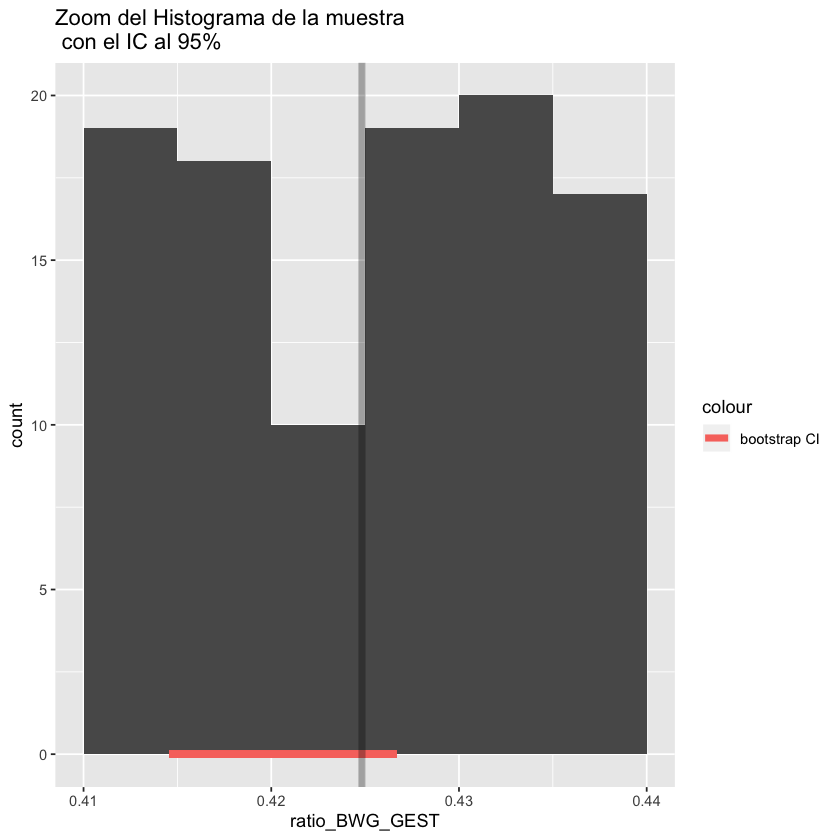

In [19]:
ggplot(babies_Sample, aes(x = ratio_BWG_GEST)) + geom_histogram(breaks = seq(0.41, 0.44, 0.005)) +
        geom_segment(aes(x = pL, y = 0, xend = pR, yend = 0, colour = "bootstrap CI"), size=2) + 
        geom_vline(xintercept = 0.4248326, size=2, alpha = 0.3) +
        ggtitle("Zoom del Histograma de la muestra \n con el IC al 95%")

### Interpretación de un Intervalo de Confianza

In [20]:
IC <- data.frame(matrix(ncol = 2, nrow = 100))
names(IC) <- c("pL", "pR")

In [21]:
for(j in 1:100){
    index <- sample(1:1236, 500)
    babies_Sample <- babies_Simple %>% slice(index)
    
    means <- bootstrapMean(babies_Sample$ratio_BWG_GEST, 5*1e3)
    pL <- percentil(means, 2.5)
    pR <- percentil(means, 97.5)
    
    IC[j, ] <- c(pL, pR)
}

Si repetimos el experimento 100 veces 95 (mas o menos) de los 100 intervalos va a contener el valor real. 

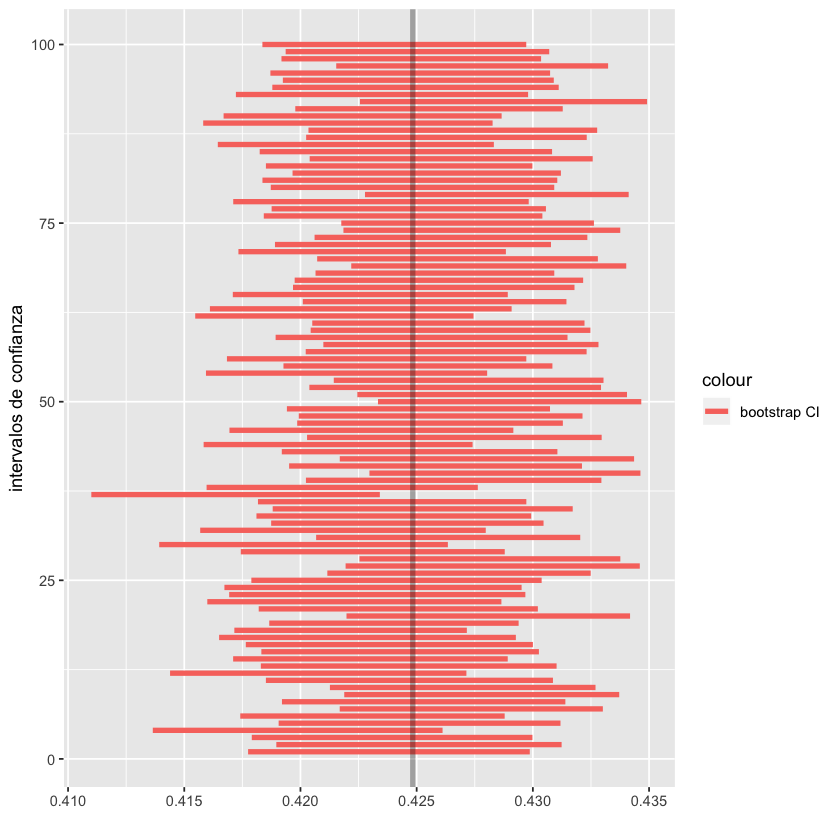

In [22]:
IC <- IC %>% mutate(ypos = 1:100)

ggplot(IC) + geom_segment(aes(x = pL, y = ypos, xend = pR, yend = ypos, colour = "bootstrap CI"), size=1.5) + 
    geom_vline(xintercept = 0.4248326, alpha = 0.3, size=1.5) + 
    xlab("") + ylab("intervalos de confianza")

## Comparar dos distribuciones(test de permutaciones)

Dos muestras: 

$$ \Large X_1, ... , X_n \sim  F$$
$$ \Large Y_1, ... , Y_m \sim G$$
  
La distribución de X y Y son iguales? 

Una idea:
0 - Calculen:

$$ \Large T = \left|\mathbb{E}(X) - \mathbb{E}(Y) \right|  $$
1 - Pongan todas las variables en un vector 

$$ \Large Z = (X_1, ... , X_n, Y_1, ... , Y_m) $$

2 - Permuten las entradas:

$$ \Large  
\begin{align*}
\pi  Z  &=(\underbrace{X_3,Y_1, Y_9, ... , X_3}_{n-elementos}, \underbrace{X_{10}, X_8, ... Y_{13}, Y_2}_{m-elementos}) \\
        &= (\pi X, \pi Y)
\end{align*}
$$

y calculen: 

$$ \Large T^{(\pi)}= \left |\mathbb{E}(\pi X) - \mathbb{E}(\pi Y) \right| $$

Si calculan $J$ permutaciones van a tener una secuencia de T's: 

$$ \Large T^{(\pi_1)}, T^{(\pi_2)}, ... , T^{(\pi_J)},$$

Calculen el cuantíl de T: 

$$ \Large T^{(\pi_1)}, T^{(\pi_2)}, ... , T^{(\pi_{330})}, \underbrace{}_{T}, T^{(\pi_{331})}, ...  T^{(\pi_J)} $$  

Si $T$ es un 90 cuantíl, entonces es mas raro que el 90% de los datos y hay una buena probabilidad que las F y G sean diferentes.  


### Intuición de por qué funciona: 

Si las dos distribuciones son iguales, permutar los datos no debería cambia T. 

In [23]:
head(babies)

bwt,gestation,parity,age,height,weight,smoke
<int>,<int>,<int>,<int>,<int>,<int>,<int>
120,284,0,27,62,100,0
113,282,0,33,64,135,0
128,279,0,28,64,115,1
123,999,0,36,69,190,0
108,282,0,23,67,125,1
136,286,0,25,62,93,0


In [24]:
babies_smoke <- babies %>% filter(smoke == 1, bwt < 200)
babies_dont <- babies %>% filter(smoke == 0, bwt < 200)

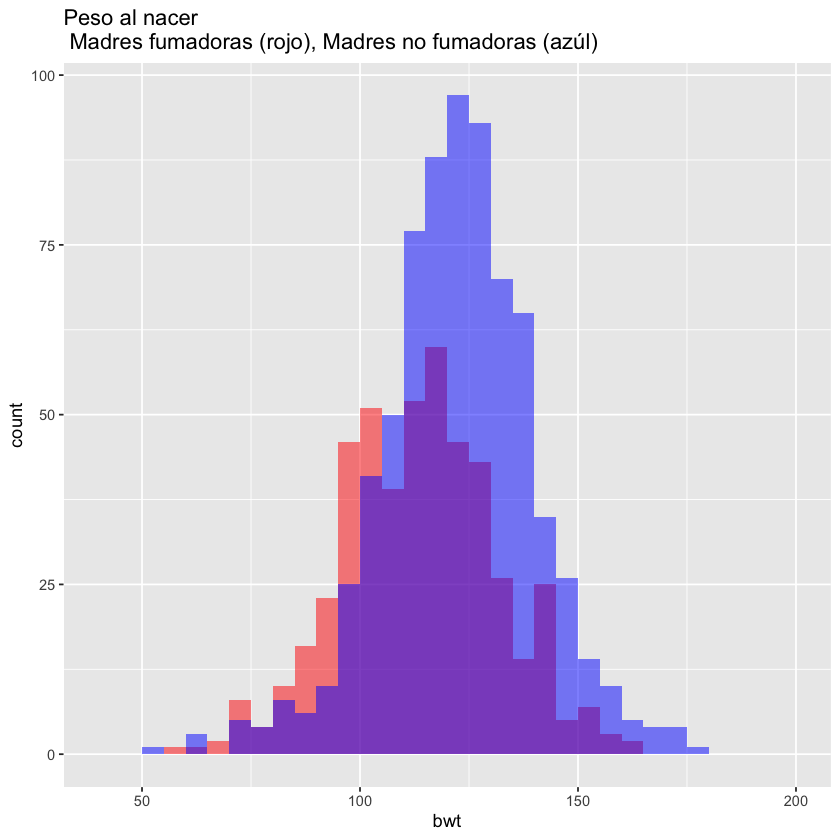

In [25]:
ggplot() + geom_histogram(data = babies_smoke, aes(x = bwt), breaks = seq(40, 200, 5), fill = "red", alpha=0.5) +
        geom_histogram(data = babies_dont, aes(x = bwt), breaks = seq(40, 200, 5), fill = "blue", alpha=0.5) +
        ggtitle("Peso al nacer \n Madres fumadoras (rojo), Madres no fumadoras (azúl)")

### Fumar tiene un efecto sobre el peso al nacer? 

Dos dos distribuciones:

    - F: Madres fumadoras. 
    - N: Madres no fumadoras. 
    
Son iguales?

H0: F = G.

In [26]:
dim(babies_smoke) 
dim(babies_dont)

[1] 484   7

[1] 742   7

Hay 484 muestras de F y 742 de N.  

In [27]:
permutationTest <- function(X, Y, J){
    # Test de permutaciones para la diferencia del promedio de dos observaiones. 
    # inputs: X, Y dos vectores. 
    #         J número de permutaciones. 
    # output: Muestras de la estadística del test. T = |mean(X) - mean(Y)|
    
    nX <- length(X)
    nY <- length(Y)
    Tpi <- rep(0, (nX + nY))
    
    Z <- c(X, Y)
    
    for(j in 1:J){
        iX <- sample(1:(nX + nY), nX)
        Xpi <- Z[iX]
        Ypi <- Z[-iX]
        Tpi[j] <- abs(mean(Xpi) - mean(Ypi))
    }
    
    return(Tpi)
}

In [28]:
X <- babies_smoke$bwt
Y <- babies_dont$bwt
J <- 1e5

T <- abs(mean(X) - mean(Y))
Tpi <- permutationTest(X, Y, J)

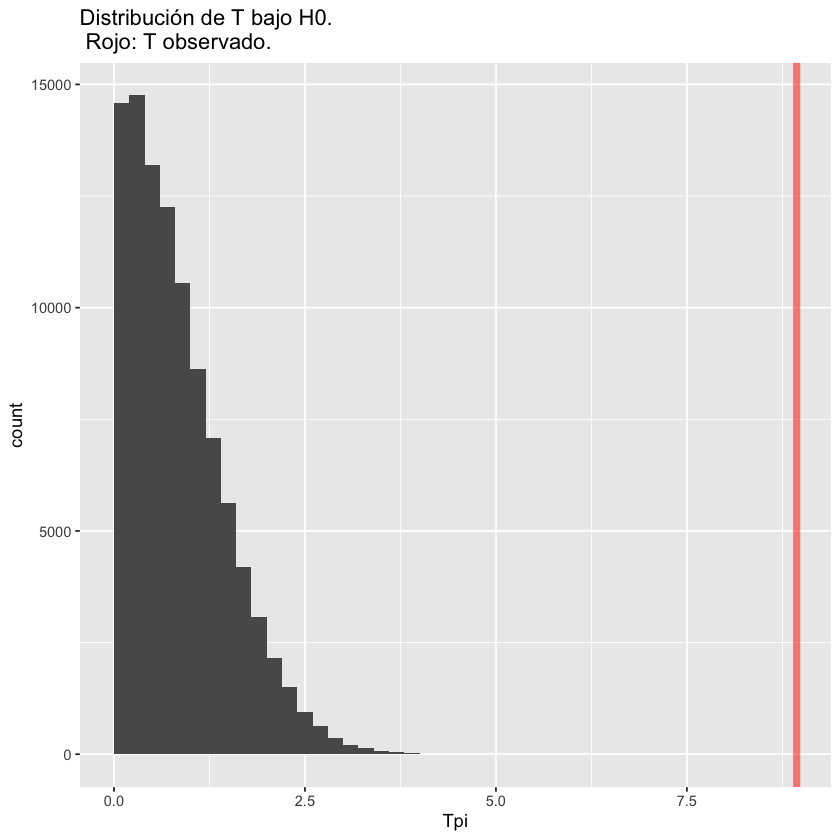

In [29]:
Tpi <- data.frame(Tpi)

ggplot(Tpi, aes(x = Tpi)) + geom_histogram(breaks = seq(0, 4, 0.2)) + 
        geom_vline(xintercept = T, size = 2, color = "red", alpha = 0.5) +
        ggtitle("Distribución de T bajo H0. \n Rojo: T observado.")

La diferencia observada (T) en rojo no es consistente con la distribución de T cuando asumimos que F = N.  

In [30]:
B <- 1e4

mX_boot <- bootstrapMean(X, B)
mY_boot <- bootstrapMean(Y, B)

bootCI <- data.frame(mX_boot, mY_boot) %>% mutate(dif = mY_boot - mX_boot) 
head(bootCI)

mX_boot,mY_boot,dif
<dbl>,<dbl>,<dbl>
114.0372,123.1240,9.086799
115.8554,122.3679,6.512553
116.4897,122.8383,6.348606
114.6736,122.8342,8.160678
114.0868,123.7709,9.684113
112.6694,122.2102,9.540821


In [31]:
pL <- percentil(bootCI$dif, 2.5)
pR <- percentil(bootCI$dif, 97.5)

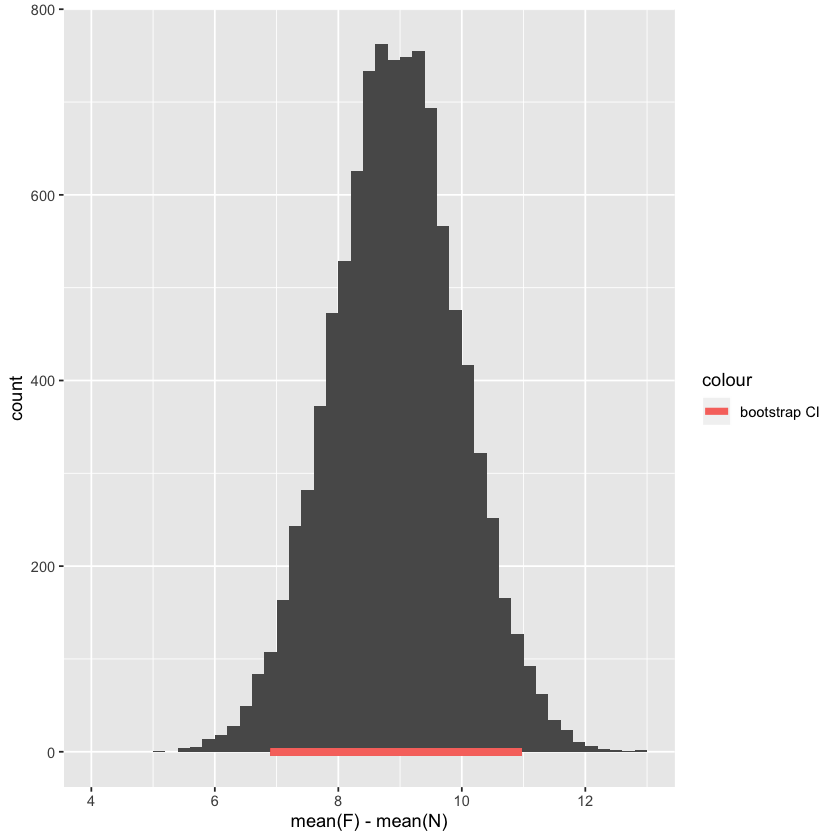

In [32]:
ggplot(bootCI, aes(x = dif)) + geom_histogram(breaks = seq(4, 13, 0.2)) + 
    geom_segment(aes(x = pL, y = 0, xend = pR, yend = 0, colour = "bootstrap CI"), size=2) +
    xlab("mean(F) - mean(N)")

El gráfico de arriba muestra un intervalo de confianza al 95% de la diferencia entre los promedios de F y N. 

- Como no contiene 0, las dos distribuciones son diferentes. 
- También nos da una idea de que tan diferentes: por lo menos 5 onzas de diferencia. 